<a href="https://colab.research.google.com/github/Qibzz/customer-segmentation-rfm-with-kmeans/blob/main/Customer_Segmentation_dengan_Analisis_RFM_(Marketing_%26_Sales)_with_K_Meansipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding
Latar Belakang: Dalam dunia ritel yang kompetitif, memperlakukan semua pelanggan dengan cara yang sama adalah strategi yang tidak efisien. Perusahaan perlu memahami perilaku pelanggan untuk memberikan treatment yang tepat.

Tujuan: Melakukan segmentasi pelanggan menggunakan metode RFM (Recency, Frequency, Monetary) dan algoritma K-Means Clustering untuk mengidentifikasi kelompok pelanggan (seperti Pelanggan Setia, Pelanggan Berisiko Churn, dll) agar tim marketing bisa membuat kampanye yang lebih terarah.

Manfaat Bisnis: Hasil segmentasi ini akan membantu tim pemasaran dalam merancang strategi promosi yang dipersonalisasi, meningkatkan customer loyalty, dan mencegah kehilangan pelanggan (churn).

# Data Loading & Merging
Dataset yang digunakan berasal dari Online Retail II (UCI Machine Learning REpository) yang mencakup transaksi penjualan online selama dua tahun (2009-2011). Karena data terpecah menjadi dua file yang terpisah, langkah pertama adalah memuat kedua file tersebut dan menggabungkannya menjadi satudataset tunggal untuk analisis historis yang komprehensif

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Load Data
df_1 = pd.read_excel("/content/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_2 = pd.read_excel("/content/online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [ ]:
#Merge Data
df = pd.concat([df_1, df_2], ignore_index = True)

In [ ]:
df.shape

(1067371, 8)

# Data Cleaningg and Preprocessing

In [ ]:
#cek missing value
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [ ]:
#hapus baris yang tidak memiliki CustomerID
df = df.dropna(subset=['Customer ID'])

In [ ]:
#hapus transaksi batal (Invoice diawali huruf C)
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [ ]:
#menghapus baris jika Quality dan Harganya nol atau negatif
df = df[(df['Quantity'] > 0) & (df['Price'])]

In [ ]:
#Membuat kolom TotalSales (omzet = jumalh x harga)
df['TotalSales'] = df['Quantity'] * df['Price']

In [ ]:
#mengubah tipe data tanggal agar dapat menghitung selisih harinya
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
#cek perbandingan data sebelum dan sesudah
print(f"Total Data Awal   : {df.shape[0]} baris")
print(f"Total Data Bersih : {df.shape[0]} baris")
print(f"Data Yang Dibuang : {df.shape[0] - df.shape[0]} baris")

Total Data Awal   : 805549 baris
Total Data Bersih : 805549 baris
Data Yang Dibuang : 0 baris


# Menghitung RFM
Algoritma K-Means membutuhkan input data tabular per pelanggan. Oleh karena itu, kita akan melakukan agregasi data untuk menghitung metrik RFM bagi setiap pelanggan:

Recency (R): Berapa hari yang lalu pelanggan terakhir kali berbelanja? (Semakin kecil semakin baik).

Frequency (F): Seberapa sering pelanggan berbelanja? (Semakin besar semakin baik).

Monetary (M): Berapa total uang yang dibelanjakan pelanggan? (Semakin besar semakin baik).

In [ ]:
#set tanggal referensi
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days = 1)

In [ ]:
#menghitung R F M per customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique', #frequency (jumlah struk unik)
    'TotalSales': 'sum' #monetary (Total uang yang keluar)
})

In [ ]:
#rename agar lebih sinkron dan mudah dibaca
rfm.rename(columns = {
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace = True)

In [ ]:
print ("Sample Data RFM:")
display(rfm.head())

Sample Data RFM:


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


# K-Means Clustering
Pada tahap ini, kita menjalankan algoritma K-Means untuk mengelompokkan pelanggan. Sebelumnya, data akan disesuaikan skalanya (*scaling*) agar hasil pengelompokan lebih akurat.

In [ ]:
# Log Trnasform (agar data tidak njoplang)
rfm_log = np.log1p(rfm)

In [ ]:
#Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [ ]:
# Elbow Method (mencari K Terbaik)
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state =42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

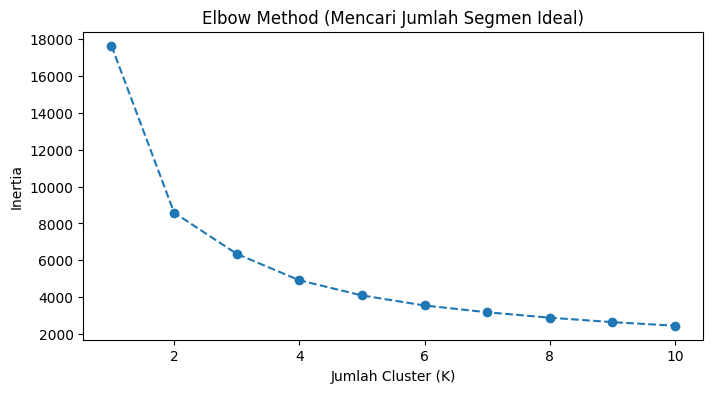

In [ ]:
#plot grafiknya
plt.figure(figsize=(8,4))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method (Mencari Jumlah Segmen Ideal)')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia')
plt.show()

In [46]:
#Training Final
kmeans_final = KMeans(n_clusters = 3, random_state = 42, n_init=10)
kmeans_final.fit(rfm_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [47]:
#simpan label cluster ke data asli
rfm['Cluster'] = kmeans_final.labels_
print("Clustering selesai✅")

Clustering selesai✅


In [60]:
rfm_reset = rfm.reset_index()

In [69]:
#Hitung rata-rata RFM per Cluster
cluster_summary = rfm.reset_index().groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).round(1) #membulatkan 1 angka desimal

In [51]:
#ganti nama kolom count
cluster_summary.rename(columns={'CustomerID': 'Jumlah_User'}, inplace=True)
print("\n--- PROFIL SEGMEN PELANGGAN ---")
display(cluster_summary)


--- PROFIL SEGMEN PELANGGAN ---


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         109.0       4.4   1556.4  2268
1         373.9       1.5    402.0  2397
2          32.9      19.3  10923.2  1213

# VISUALISASI

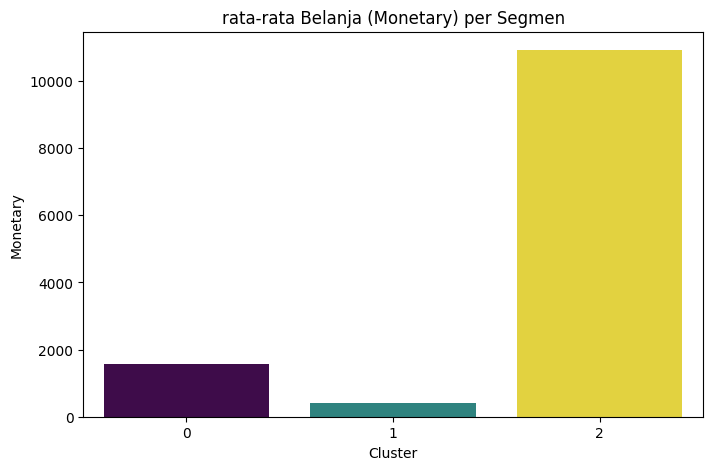

In [73]:
# Visualisasi Bar Chart(monetary)
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_summary.index, y=cluster_summary['Monetary'], hue=cluster_summary.index, palette='viridis', legend=False)
plt.title('rata-rata Belanja (Monetary) per Segmen')
plt.xlabel('Cluster')
plt.ylabel('Monetary')
plt.show()

"Pie chart ini memperlihatkan kesehatan basis pelanggan yang sangat positif, didominasi oleh 74,3% 'Loyal Customer' yang menjadi tulang punggung pendapatan rutin bisnis. Hanya 9,3% yang masuk kategori 'VIP (Sultan)', yang wajar karena ini adalah grup eksklusif dengan nilai belanja fantastis. Namun, ada peringatan penting dari segmen 'Lost/Hibernating' sebesar 16,4%, yang menunjukkan bahwa hampir 1 dari 6 pelanggan berisiko pergi selamanya dan perlu segera 'dibangunkan' kembali lewat promosi khusus.

In [75]:
# SEGMENT INTERPRETATION
nama_segmen = {
    2: 'VIP (Sultan)',
    1: 'Loyal Customers',
    0: 'Lost / Hibernating'
}
# Masukkan nama ini ke dalam data
rfm['Segment_Name'] = rfm['Cluster'].map(nama_segmen)
display(rfm[['Recency', 'Frequency', 'Monetary', 'Segment_Name']].sample(5))



,Recency,Frequency,Monetary,Segment_Name
Customer ID,,,,
12546.0,47,2,1161.50,Lost / Hibernating
12871.0,84,3,744.02,Lost / Hibernating
17365.0,13,15,8224.98,VIP (Sultan)
13247.0,18,4,501.12,Lost / Hibernating
14775.0,58,3,1418.46,Lost / Hibernating


In [76]:
# FINAL VISUALIZATION (Pie Chart)
# Hitung jumlah orang per segmen
segment_counts = rfm['Segment_Name'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Jumlah_User']

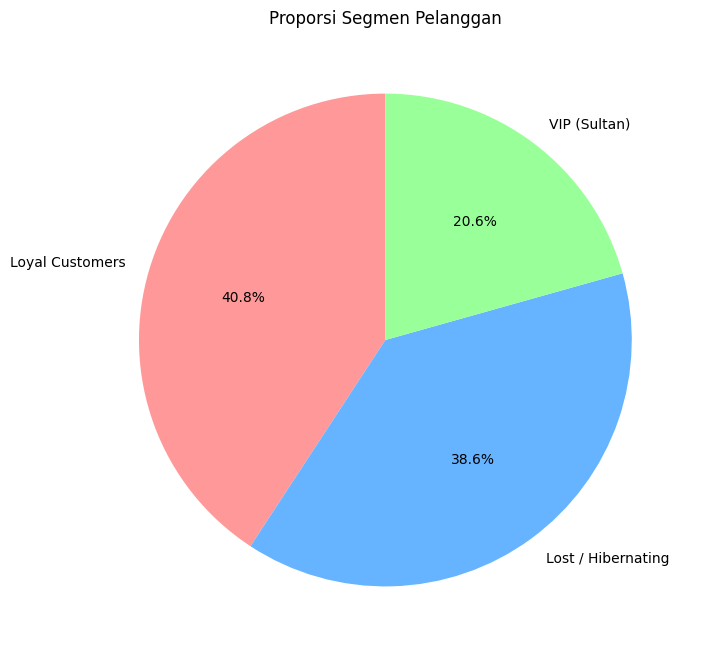

In [77]:
# Bikin Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts['Jumlah_User'],
        labels=segment_counts['Segment'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff','#99ff99'],
        startangle=90)
plt.title('Proporsi Segmen Pelanggan')
plt.show()

Terlihat jelas bahwa algoritma K-Means berhasil memisahkan segmen secara logis: kelompok 'Sultan' (kuning) mencuat tinggi ke atas karena nilai transaksi yang besar, kelompok 'Loyal' (hijau) berkumpul padat sebagai basis pelanggan aktif, sedangkan kelompok 'Lost' (ungu) menyebar menjauh secara horizontal menandakan mereka sudah lama tidak berbelanja."

Jumlah Data: 5878 baris


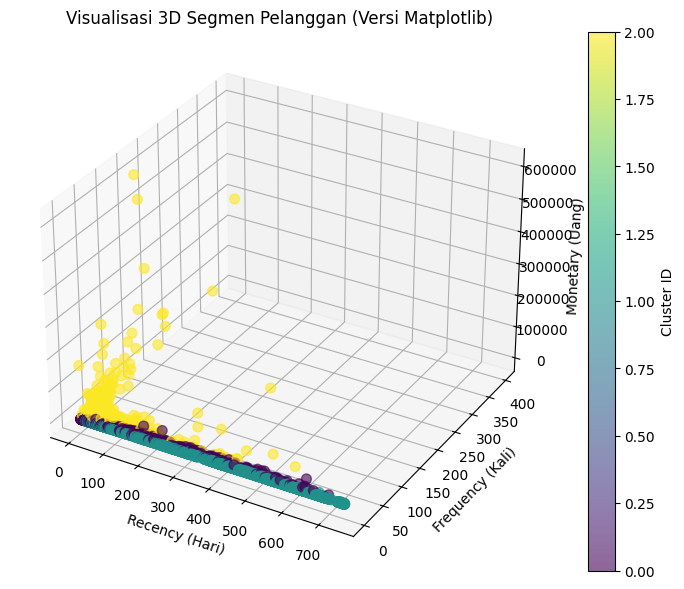

In [82]:
#Visualisasi dengan Scatter Plot
import matplotlib.pyplot as plt

# Cek data
print(f"Jumlah Data: {rfm.shape[0]} baris")

# Bikin Canvas 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')

# Plot titik-titik (Warna berdasarkan Cluster angka 0,1,2 biar aman)
scatter = ax.scatter(rfm['Recency'],
                     rfm['Frequency'],
                     rfm['Monetary'],
                     c=rfm['Cluster'], # Warna ikut cluster
                     cmap='viridis',   # Pilihan palet warna
                     s=50,             # Ukuran titik
                     alpha=0.6)        # Transparansi

# Label Sumbu
ax.set_xlabel('Recency (Hari)')
ax.set_ylabel('Frequency (Kali)')
ax.set_zlabel('Monetary (Uang)')
plt.title('Visualisasi 3D Segmen Pelanggan (Versi Matplotlib)')

# Tambah keterangan warna
plt.colorbar(scatter, label='Cluster ID')

plt.show()

Grafik 3D ini memetakan 5.878 pelanggan unik yang merupakan hasil rangkuman dari satu juta data transaksi, di mana setiap titik merepresentasikan satu orang pelanggan. Dalam ruang tiga dimensi ini, posisi setiap pelanggan ditentukan otomatis oleh pola belanja mereka: kapan terakhir beli (Recency), seberapa sering (Frequency), dan total uangnya (Monetary). Terlihat jelas bahwa algoritma K-Means berhasil memisahkan mereka secara logis: pelanggan 'Sultan' mencuat tinggi ke atas karena nilai belanjanya fantastis, pelanggan 'Loyal' berkumpul padat di area aktif, sedangkan pelanggan yang sudah 'Hilang' menyebar menjauh karena sudah lama tidak bertransaksi